In [1]:
from deap import base, creator, tools
import random
from math import sin
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [2]:
def fitnessFunction(x = []):
        return sin(x[0] + x[1]) + (x[0] - x[1])**2 - 1.5 * x[0] + 2.5 * x[1] + 1 

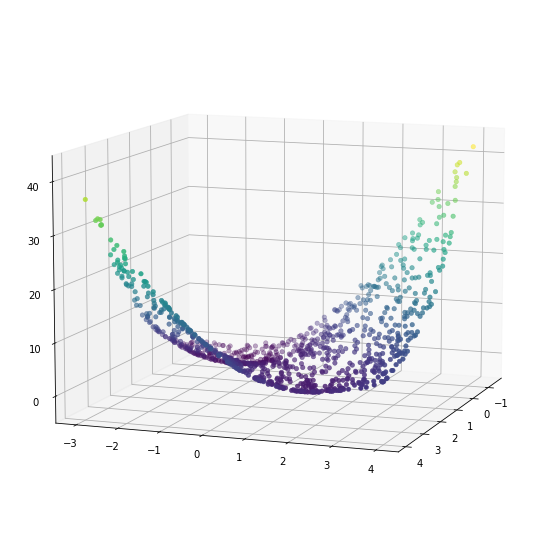

In [3]:
from mpl_toolkits import mplot3d
# %matplotlib notebook
# %matplotlib inline
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

X1 = [random.uniform(-1.5, 4) for i in range(1000)]
X2 = [random.uniform(-3, 4) for i in range(1000)]
Y = [fitnessFunction((x1, x2)) for x1, x2 in zip(X1, X2)]

#ax.plot3D(X1, X2, Y, 'gray')
ax.view_init(10, 20)
ax.scatter3D(X1, X2, Y, c=Y, cmap='viridis', linewidth=0.5)

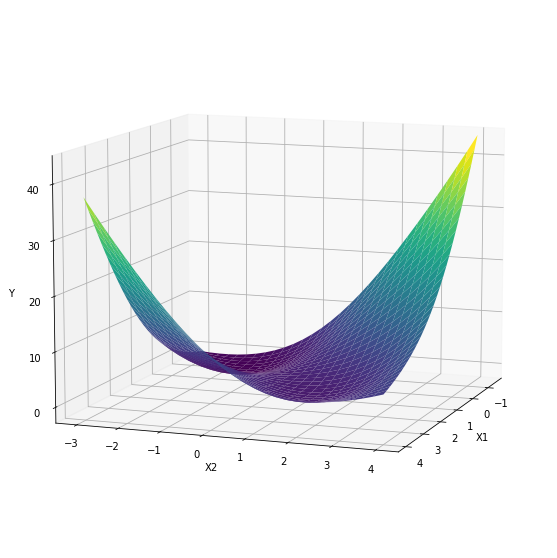

In [4]:
def mccorm(x1, x2):
        return np.sin(x1 + x2) + (x1 - x2)**2 - 1.5 * x1 + 2.5 * x2 + 1 
    
x1 = np.linspace(-1.5, 4., 30)
x2 = np.linspace(-3., 4., 30)

X1, X2 = np.meshgrid(x1, x2)

Y = mccorm(X1, X2)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
# ax.contour3D(X1, X2, Y, 100, cmap='binary')
# ax.plot_wireframe(X1, X2, Y, color='black')
ax.plot_surface(X1, X2, Y, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.view_init(10, 20)

In [5]:
sizePopulation = 100
probabilityMutation = 0.2
probabilityCrossover = 0.8
numberIteration = 100
numberElitism = 1
X1_RANGE = {'min':-1.5, 'max':4.}
X2_RANGE = {'min':-3., 'max':4.}

In [6]:
def individual(icls):
    genome = list()
    genome.append(random.uniform(-1.5, 4.))
    genome.append(random.uniform(-3., 4.))
    return icls(genome)

In [7]:
def checkBounds(x1r, x2r):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                if child[0] > x1r['max']:
                    child[0] = x1r['max']
                elif child[0] < x1r['min']:
                    child[0] = x1r['min']
                if child[1] > x2r['max']:
                    child[1] = x2r['max']
                elif child[1] < x2r['min']:
                    child[1] = x2r['min']
            return offspring
        return wrapper
    return decorator

In [8]:
def configureDeap(selection_param={'function':tools.selTournament, 'tournsize':3}, 
                  mutation_params={'function':tools.mutGaussian, 'mu':5, 'sigma':10, 'indpb':0.2},
                 mate_params={'function':tools.cxTwoPoint}):
    creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox() 
    toolbox.register('individual', individual, creator.Individual)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)
    toolbox.register('evaluate', fitnessFunction)
    toolbox.register('select', **selection_param)
    toolbox.register('mate', **mate_params)
    toolbox.register('mutate', **mutation_params)
    
    toolbox.decorate("mate", checkBounds(X1_RANGE, X2_RANGE))
    toolbox.decorate("mutate", checkBounds(X1_RANGE, X2_RANGE))
    return toolbox

In [9]:
def setIndividualFitnessValue(individuals, fitnesses):
    for ind, fit in zip(individuals, fitnesses):
        ind.fitness.value = [fit]
    return individuals

In [10]:
def initPopulation(toolbox):
    population = toolbox.population(n=100)
    fitnesses = list(map(toolbox.evaluate, population))
    population = setIndividualFitnessValue(population, fitnesses)
    return population

In [11]:
def crossover(toolbox, offspring):
    # [::2] - gets only individuals with odd indexes
    # [1::2] -  gets only individuals with even indexes
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        # crossover
        if random.random() < probabilityCrossover:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    return offspring

In [12]:
def mutate(toolbox, offspring):
    for mutant in offspring:
        # mutation
        if random.random() < probabilityMutation:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    return offspring

In [13]:
def evaluate(toolbox, offspring, verbose=0):
    # evaluate new individuals
    new_individuals = [ind for ind in offspring if not ind.fitness.valid]
    new_fitnesses = map(toolbox.evaluate, new_individuals)
    for ind, fit in zip(new_individuals, new_fitnesses):
        ind.fitness.values = [fit]
    
    if verbose>3:
        print('Ewaluated %i individuals'%len(new_individuals))
    return offspring

In [14]:
def getBestsForElitism(population):
    listElitism = []
    for x in range(0, numberElitism):
        listElitism.append(tools.selBest(population, 1)[0])
    return listElitism

In [15]:
def calculateStatistics(population,verbose=0):
    fits = [ind.fitness.values[0] for ind in population]
    length = len(population)
    mean = sum(fits)/length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2/length-mean **2)**0.5
    if verbose>2:
        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
    return (mean, std)

In [16]:
def pickBestIndividual(population, verbose=0):
    best_ind = tools.selBest(population, 1)[0]
    if verbose>1:
        print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    return best_ind

In [17]:
def plotSimple(y_vals=[], label_y='y', label_x='x', title='plot', instance_info='no_info', save_location='./plots/'):
    filename = save_location + title+'_'+ instance_info +'.png'
    x_vals = [x for x in range(len(y_vals))]
    plt.plot(x_vals, y_vals)
    plt.title(title)
    plt.ylabel(label_y)
    plt.xlabel(label_x)
#     plt.savefig(filename)
    plt.show()
    plt.close()

In [18]:
def plotResults(stats):
    plotSimple([best[0].fitness.values[0] for best in stats], 'best', 'epoch', 'fitness(iteration)')
    plotSimple([best[1] for best in stats], 'mean', 'epoch', 'mean(iteration)')
    plotSimple([best[2] for best in stats], 'std', 'epoch', 'std(iteration)')
    plotSimple([best[3] for best in stats], 'duration', 'epoch', 'epoch_duration(iteration)')

In [19]:
def startOptimizationLoop(toolbox, population, elitism=False, verbose=0):
    stats = []
    g = 0
    while g < numberIteration:
        g = g + 1
        if verbose>0:
            print('-- Generation %i --' % g)
        start = timer()  
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))
        
        elite = getBestsForElitism(offspring) if elitism else []
        
        offspring = crossover(toolbox, offspring)
        offspring = mutate(toolbox, offspring)
        offspring = evaluate(toolbox, offspring)
        duration = timer()-start
        
        population[:] = offspring + elite

        mean, std = calculateStatistics(population, verbose)
        best_ind = pickBestIndividual(population, verbose)
        stats.append((best_ind, mean, std, duration))
    
    if verbose>-1:
        best_overall = pickBestIndividual(population, verbose)
        print('Best found individual: (x1,x2) =', best_overall, ', y =', best_overall.fitness.values[0])
    return stats

In [20]:
def run(selection, mutation, mate, elitism, verbose):
    toolbox = configureDeap(selection, mutation, mate)
    population = initPopulation(toolbox)
    stats = startOptimizationLoop(toolbox, population, elitism, verbose)
    plotResults(stats)

Best found individual: (x1,x2) = [-0.49763323947782134, -1.538442653767846] , y = -1.9100687050360627


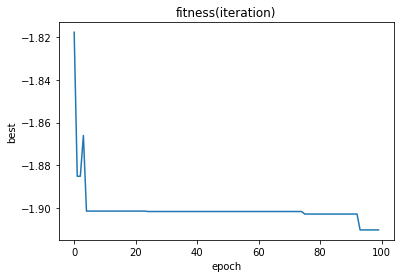

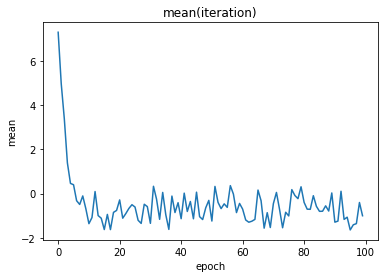

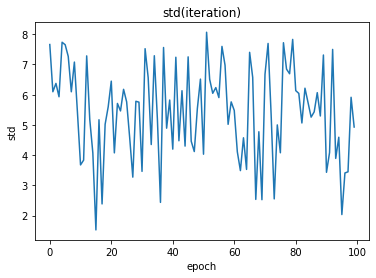

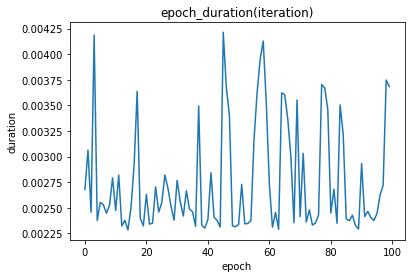

In [21]:
# scenario 0 (tournament, mutGaussian, cxTwoPoint, with elitism):
selection={'function':tools.selTournament, 'tournsize':3} 
mutation={'function':tools.mutGaussian, 'mu':5, 'sigma':10, 'indpb':0.2}
# mutation={'function':tools.mutGaussian, 'mu':0.0, 'sigma':0.2, 'indpb':0.2}
mate={'function':tools.cxTwoPoint}
elitism = False
verbose = 0
run(selection, mutation, mate, elitism, verbose)

C:\Users\dtms\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\dtms\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Best found individual: (x1,x2) = [-0.5346429183542014, -1.5257710620995568] , y = -1.9126410165920436


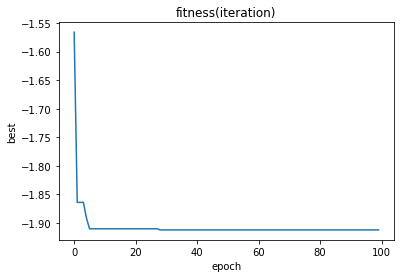

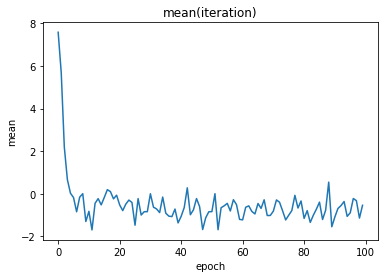

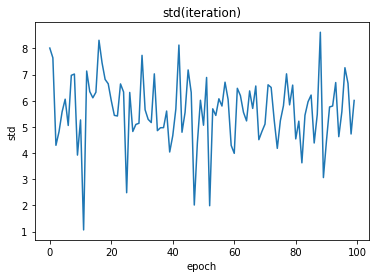

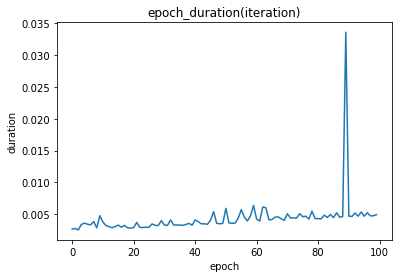

In [22]:
# scenario 0 (tournament, mutGaussian, cxTwoPoint, with elitism):
selection={'function':tools.selTournament, 'tournsize':3} 
mutation={'function':tools.mutGaussian, 'mu':5, 'sigma':10, 'indpb':0.2}
mate={'function':tools.cxTwoPoint}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)

Best found individual: (x1,x2) = [-0.9263144422919275, -1.7260082625338755] , y = -1.7560204013821474


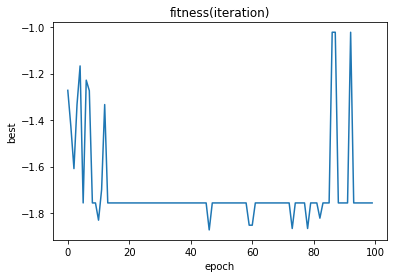

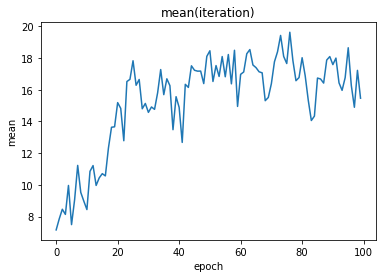

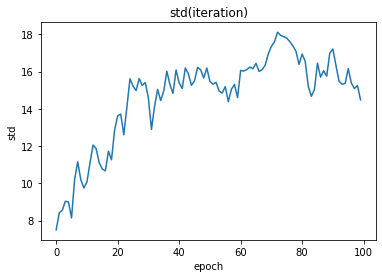

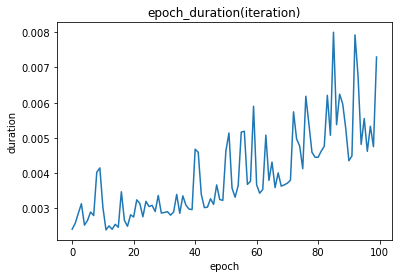

In [23]:
# scenario 1 (selRandom, mutGaussian, cxTwoPoint, with elitism):
selection={'function':tools.selRandom} 
mutation={'function':tools.mutGaussian, 'mu':5, 'sigma':10, 'indpb':0.2}
mate={'function':tools.cxTwoPoint}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)

Best found individual: (x1,x2) = [-0.5579424371234198, -1.5303438254310082] , y = -1.912445093531364


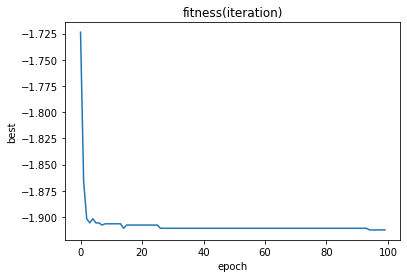

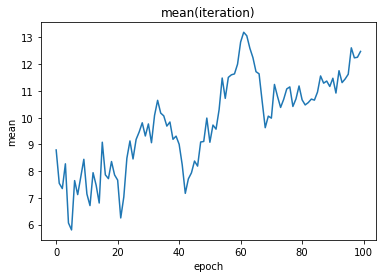

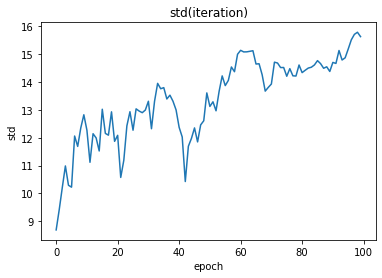

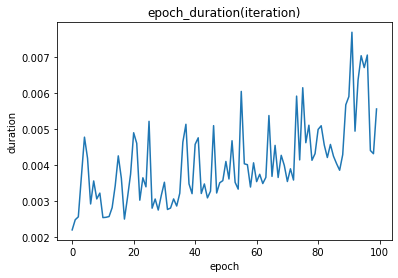

In [24]:
# scenario 2 (selBest, mutGaussian, cxTwoPoint, with elitism):
selection={'function':tools.selBest} 
mutation={'function':tools.mutGaussian, 'mu':5, 'sigma':10, 'indpb':0.2}
mate={'function':tools.cxTwoPoint}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)

Best found individual: (x1,x2) = [-1.5, -3.0] , y = -1.022469882334903


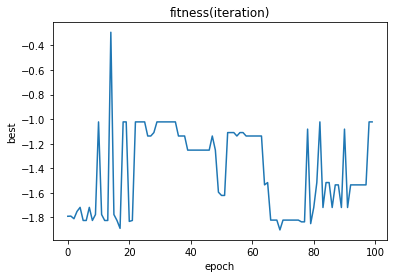

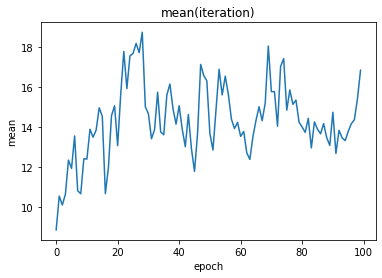

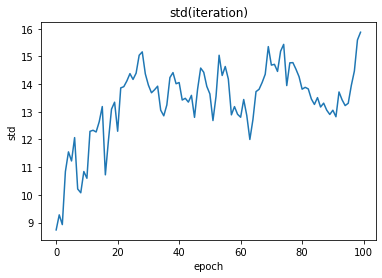

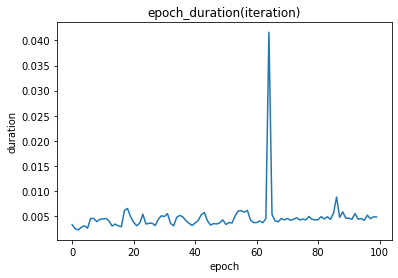

In [25]:
# scenario 3 (selWorst, mutGaussian, cxTwoPoint, with elitism):
selection={'function':tools.selRandom} 
mutation={'function':tools.mutGaussian, 'mu':5, 'sigma':10, 'indpb':0.2}
mate={'function':tools.cxTwoPoint}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)

Best found individual: (x1,x2) = [-0.5252982245745457, -1.4960085824085523] , y = -1.9100204641041807


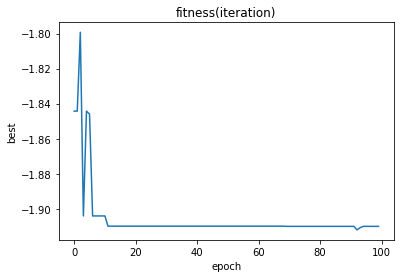

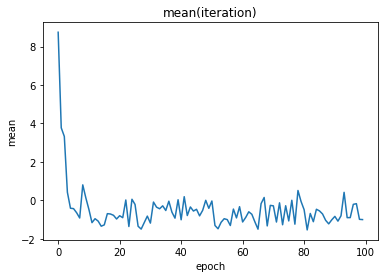

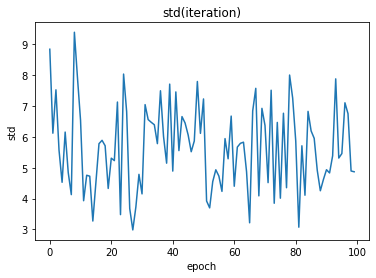

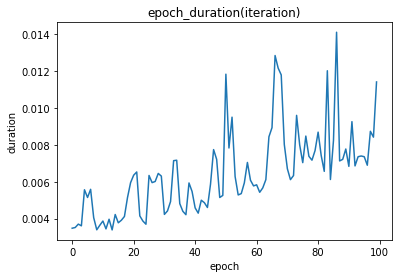

In [26]:
# scenario 4 (selDoubleTournament, mutGaussian, cxTwoPoint, with elitism):
selection={'function':tools.selDoubleTournament, 'fitness_size':3, 'parsimony_size':2, 'fitness_first':True} 
mutation={'function':tools.mutGaussian, 'mu':5, 'sigma':10, 'indpb':0.2}
mate={'function':tools.cxTwoPoint}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)

Best found individual: (x1,x2) = [-0.5151170325625385, -1.5361742363478386] , y = -1.9119684888079709


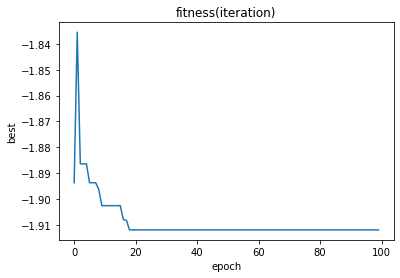

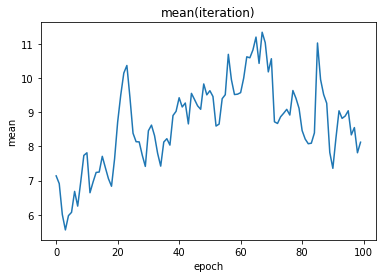

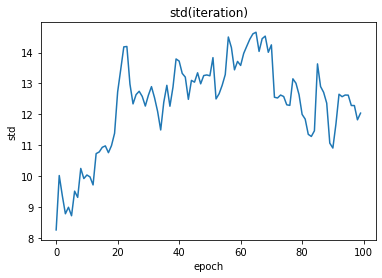

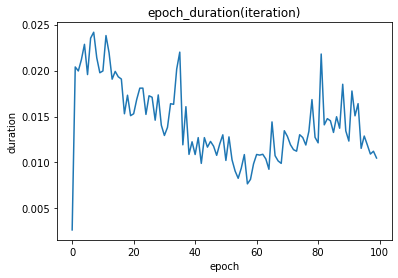

In [27]:
# scenario 5 (selNSGA2, mutGaussian, cxTwoPoint, with elitism):
selection={'function':tools.selNSGA2, 'nd':'standard'} 
mutation={'function':tools.mutGaussian, 'mu':5, 'sigma':10, 'indpb':0.2}
mate={'function':tools.cxTwoPoint}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)

Best found individual: (x1,x2) = [-0.5539246052450932, -1.5354114076407805] , y = -1.9128691230342802


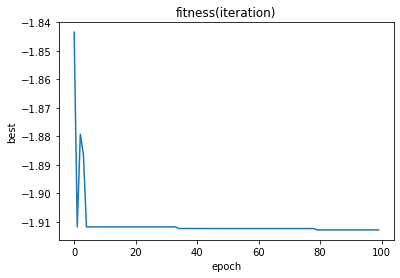

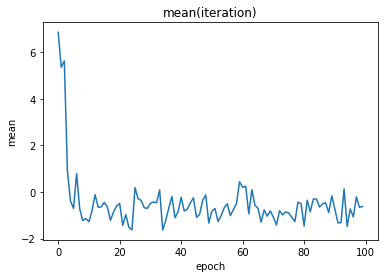

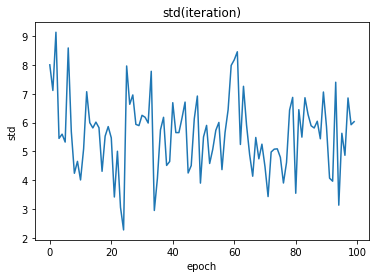

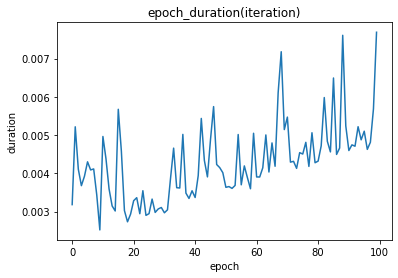

In [30]:
# scenario 6 (tournament, mutGaussian, cxOnePoint, with elitism): 
selection={'function':tools.selTournament, 'tournsize':3} 
mutation={'function':tools.mutGaussian, 'mu':5, 'sigma':10, 'indpb':0.2}
# mutation={'function':tools.mutGaussian, 'mu':0.0, 'sigma':0.2, 'indpb':0.2}
mate={'function':tools.cxOnePoint}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)

Best found individual: (x1,x2) = [-0.530517299077796, -1.5840731279330222] , y = -1.9101788158329178


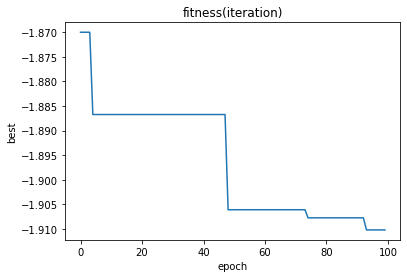

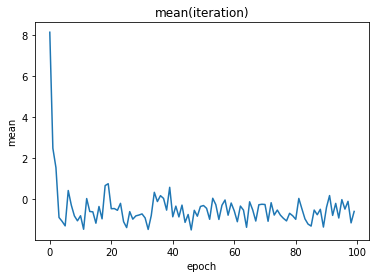

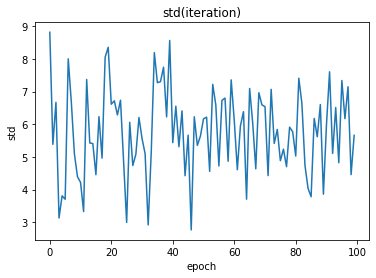

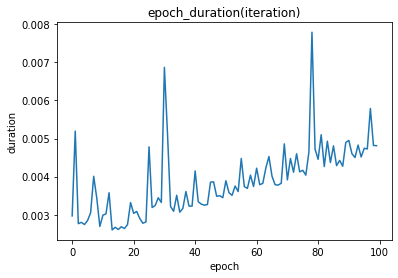

In [32]:
# scenario 7 (tournament, mutGaussian, cxUniformcxUniform, with elitism): 
selection={'function':tools.selTournament, 'tournsize':3} 
mutation={'function':tools.mutGaussian, 'mu':5, 'sigma':10, 'indpb':0.2}
# mutation={'function':tools.mutGaussian, 'mu':0.0, 'sigma':0.2, 'indpb':0.2}
mate={'function':tools.cxUniform, 'indpb':0.8}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)

Best found individual: (x1,x2) = [-0.5471975478486011, -1.54719755301081] , y = -1.9132229549810367


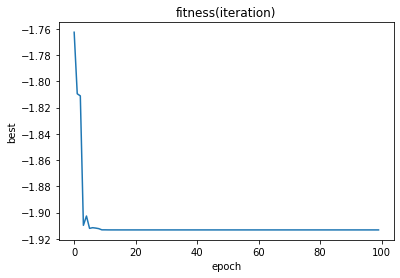

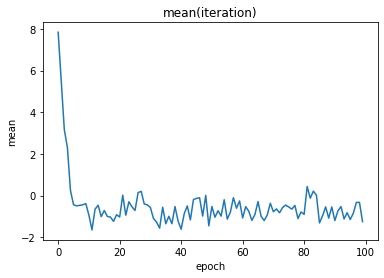

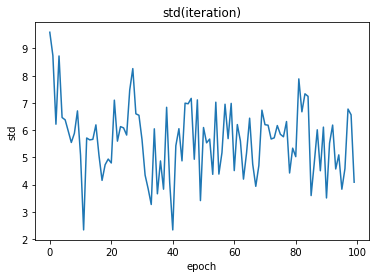

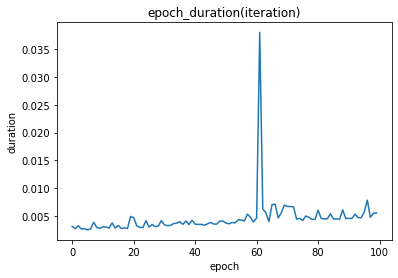

In [35]:
# scenario 8 (tournament, mutGaussian, cxBlend, with elitism): 
selection={'function':tools.selTournament, 'tournsize':3} 
mutation={'function':tools.mutGaussian, 'mu':5, 'sigma':10, 'indpb':0.2}
# mutation={'function':tools.mutGaussian, 'mu':0.0, 'sigma':0.2, 'indpb':0.2}
mate={'function':tools.cxBlend, 'alpha':0.5}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)

Best found individual: (x1,x2) = [-0.6029255528785171, -1.5718862844034385] , y = -1.9095041217023292


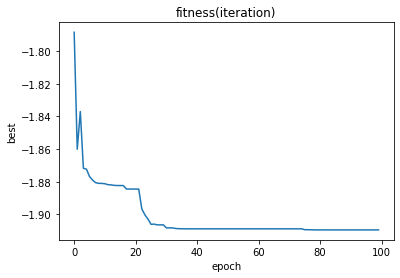

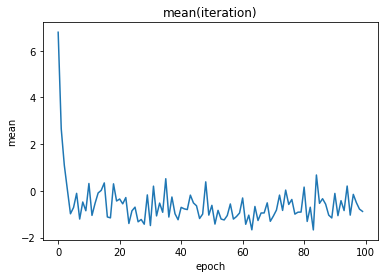

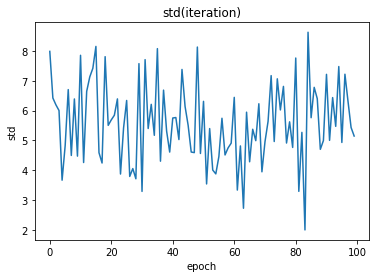

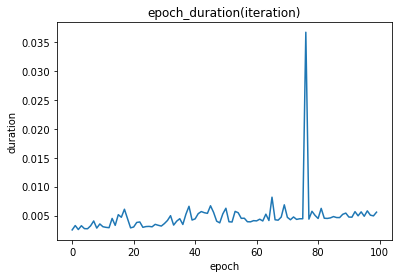

In [40]:
# scenario 9 (tournament, mutGaussian, cxSimulatedBinary, with elitism): 
selection={'function':tools.selTournament, 'tournsize':3} 
mutation={'function':tools.mutGaussian, 'mu':5, 'sigma':10, 'indpb':0.2}
# mutation={'function':tools.mutGaussian, 'mu':0.0, 'sigma':0.2, 'indpb':0.2}
mate={'function':tools.cxSimulatedBinary, 'eta':-10}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)

Best found individual: (x1,x2) = [-0.5318489970159567, -1.5915243576575393] , y = -1.9093002418216134


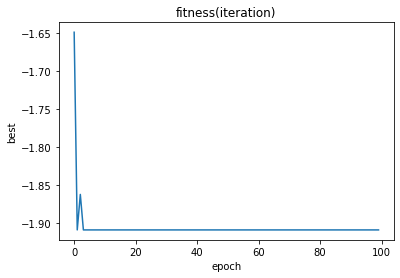

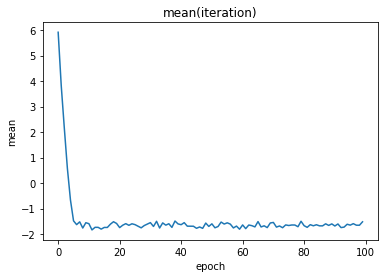

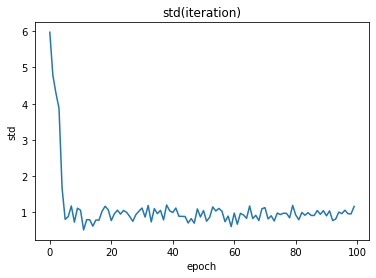

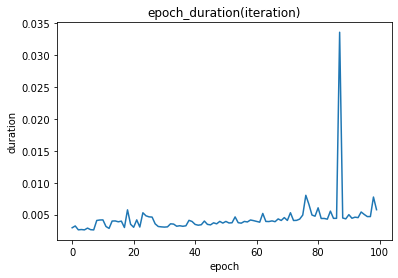

In [60]:
# scenario 10 (tournament, mutShuffleIndexes, cxTwoPoint, with elitism): 
selection={'function':tools.selTournament, 'tournsize':3} 
mutation={'function':tools.mutShuffleIndexes, 'indpb':0.2}
mate={'function':tools.cxTwoPoint}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)

Best found individual: (x1,x2) = [-0.5744981152277066, -1.4315177626762] , y = -1.8893420570585242


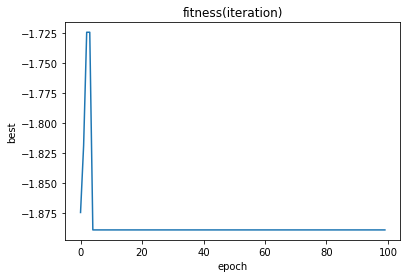

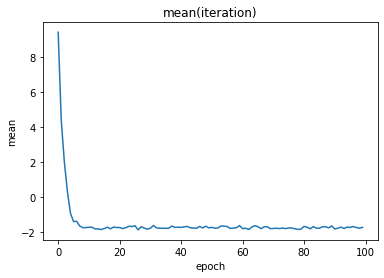

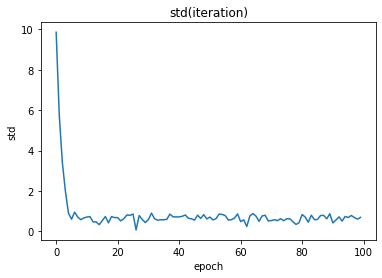

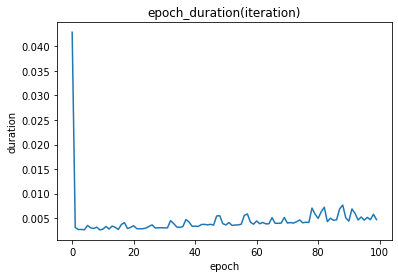

In [59]:
# scenario 11 (tournament, mutFlipBit, cxTwoPoint, with elitism): 
selection={'function':tools.selTournament, 'tournsize':3} 
mutation={'function':tools.mutFlipBit, 'indpb':0.2}
mate={'function':tools.cxTwoPoint}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)

Best found individual: (x1,x2) = [-0.4193298414050304, -1.475021892687456] , y = -1.89218527106507


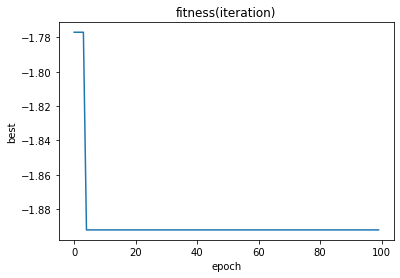

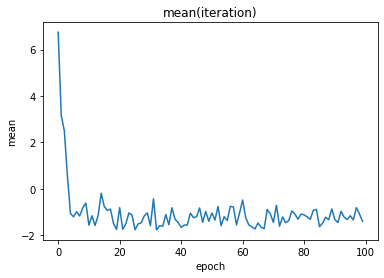

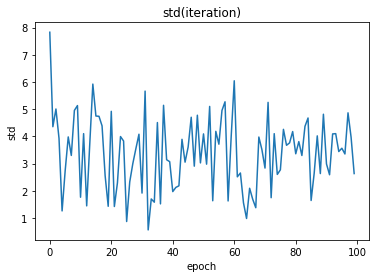

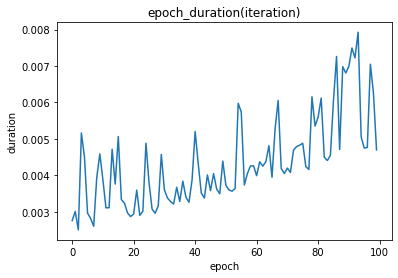

In [58]:
# scenario 12 (tournament, mutUniformInt, cxTwoPoint, with elitism): 
selection={'function':tools.selTournament, 'tournsize':3} 
mutation={'function':tools.mutUniformInt, 'indpb':0.2, 'low':-4.0, 'up': 4.0}
mate={'function':tools.cxTwoPoint}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)

Best found individual: (x1,x2) = [-0.5643245915848965, -1.5596599239257474] , y = -1.912824265229152


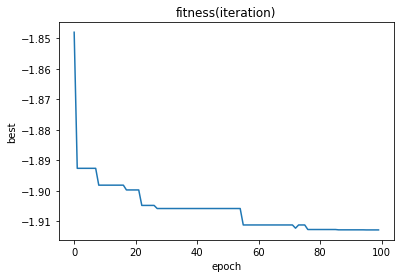

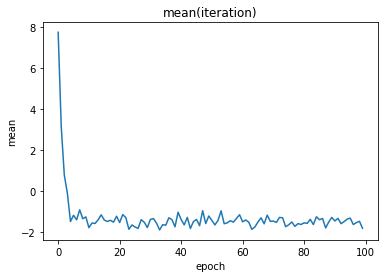

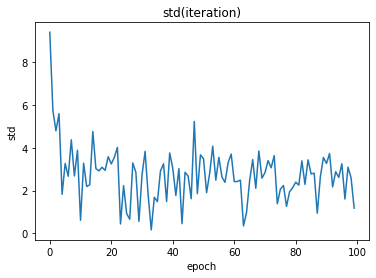

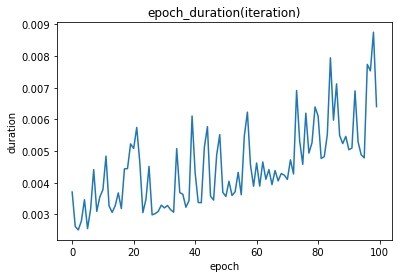

In [56]:
# scenario 14 (tournament, mutPolynomialBounded, cxTwoPoint, with elitism): 
selection={'function':tools.selTournament, 'tournsize':3} 
mutation={'function':tools.mutPolynomialBounded, 'eta':0.2, 'low':-4.0, 'up': 4.0, 'indpb':0.2}
mate={'function':tools.cxTwoPoint}
elitism = True
verbose = 0
run(selection, mutation, mate, elitism, verbose)